# **Data Quest Challenge**
- Team  : TheOne
- Author: Harry Mardika

## Import Library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import OrdinalEncoder
from category_encoders import TargetEncoder
from sklearn.metrics import roc_auc_score, roc_curve, auc, classification_report, confusion_matrix

from catboost import CatBoostClassifier
import optuna

import warnings
warnings.filterwarnings('ignore')

## Konfigurasi Awal

In [ ]:
DATA_PATH = 'data/'
TRAIN_FILE = DATA_PATH + 'training_dataset.csv'
TEST_FILE = DATA_PATH + 'validation_set.csv'
OUTPUT_FILE = DATA_PATH + 'DCM_DMU_2025_Model_TheOne.csv'

ID_COL = 'customer_number'
TARGET_COL = 'berlangganan_deposito'

RANDOM_STATE = 42
N_SPLITS = 5
N_TRIAL = 30

np.random.seed(RANDOM_STATE)

## Data Loading

In [3]:
df_train = pd.read_csv(TRAIN_FILE)
df_test = pd.read_csv(TEST_FILE)

## Definisi & Pemisahan Fitur

In [4]:
numerical_cols = [
    'usia', 'jumlah_kontak_kampanye_ini', 'hari_sejak_kontak_sebelumnya',
    'jumlah_kontak_sebelumnya', 'tingkat_variasi_pekerjaan',
    'indeks_harga_konsumen', 'indeks_kepercayaan_konsumen',
    'suku_bunga_euribor_3bln', 'jumlah_pekerja'
]
pendidikan_order = [
    'unknown', 'TIDAK SEKOLAH', 'Tidak Tamat SD', 'SD', 'SMP', 'SMA', 'Diploma', 'Pendidikan Tinggi'
]

In [5]:
ordinal_cols_map = {'pendidikan': pendidikan_order}
ordinal_cols = list(ordinal_cols_map.keys())

In [6]:
all_cols = df_train.columns.tolist()
categorical_cols = [col for col in all_cols if df_train[col].dtype == 'object']
nominal_cols = [
    col for col in categorical_cols if col not in ordinal_cols and col != TARGET_COL
]
potential_cat_cols = df_train.select_dtypes(include=['object', 'category']).columns.tolist()
for col in potential_cat_cols:
    if col not in ordinal_cols and col not in nominal_cols and col != TARGET_COL:
        if col not in numerical_cols and col not in [ID_COL, TARGET_COL]:
             nominal_cols.append(col)
nominal_cols = list(set(nominal_cols))

print(f"Kolom Numerik: {numerical_cols}")
print(f"Kolom Ordinal: {ordinal_cols}")
print(f"Kolom Nominal: {nominal_cols}")

Kolom Numerik: ['usia', 'jumlah_kontak_kampanye_ini', 'hari_sejak_kontak_sebelumnya', 'jumlah_kontak_sebelumnya', 'tingkat_variasi_pekerjaan', 'indeks_harga_konsumen', 'indeks_kepercayaan_konsumen', 'suku_bunga_euribor_3bln', 'jumlah_pekerja']
Kolom Ordinal: ['pendidikan']
Kolom Nominal: ['jenis_kontak', 'pulau', 'status_perkawinan', 'gagal_bayar_sebelumnya', 'hasil_kampanye_sebelumnya', 'pinjaman_pribadi', 'bulan_kontak_terakhir', 'pekerjaan', 'pinjaman_rumah', 'hari_kontak_terakhir']


In [7]:
X = df_train.drop(columns=[ID_COL, TARGET_COL])
y = df_train[TARGET_COL]
X_test_final = df_test.drop(columns=[ID_COL])
customer_numbers_test = df_test[ID_COL]

In [8]:
temp_X_processed_cols = X.columns.tolist()
catboost_categorical_ft_indices = [temp_X_processed_cols.index(col) for col in ordinal_cols if col in temp_X_processed_cols]

print(f"Indeks fitur kategorikal (berbasis urutan kolom asli) untuk CatBoost: {catboost_categorical_ft_indices}")

Indeks fitur kategorikal (berbasis urutan kolom asli) untuk CatBoost: [3]


## Distribusi Target

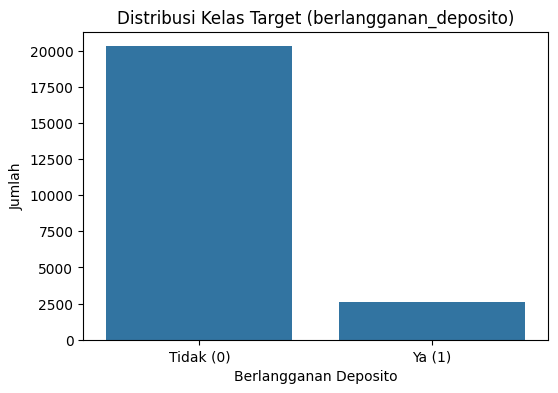

berlangganan_deposito
0    0.885931
1    0.114069
Name: proportion, dtype: float64


In [9]:
plt.figure(figsize=(6, 4))
sns.countplot(x=y)
plt.title('Distribusi Kelas Target (berlangganan_deposito)')
plt.xlabel('Berlangganan Deposito'); plt.ylabel('Jumlah')
plt.xticks([0, 1], ['Tidak (0)', 'Ya (1)']); plt.show()
print(y.value_counts(normalize=True))

## Modelling

In [10]:
skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_STATE)

In [ ]:
auc_scores_model_ref = []
oof_preds_model_ref = np.zeros(len(X))
print("\n--- Melatih Model Referensi: CatBoost dengan class_weight yang dihitung ---")

for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
    print(f"Fold {fold+1}/{N_SPLITS}")
    X_train_fold, X_val_fold = X.iloc[train_idx].copy(), X.iloc[val_idx].copy()
    y_train_fold, y_val_fold = y.iloc[train_idx], y.iloc[val_idx]

    oe_fold_map = {}
    for col, order in ordinal_cols_map.items():
        unique_train_cats = X_train_fold[col].unique()
        current_categories_fold = [cat for cat in order if cat in unique_train_cats]
        if not current_categories_fold:
            X_train_fold[col] = -1; X_val_fold[col] = -1
            print(f"Peringatan: Tidak ada kategori yang cocok untuk {col} di fold {fold+1}. Diisi dengan -1.")
            continue
        oe = OrdinalEncoder(categories=[current_categories_fold], handle_unknown='use_encoded_value', unknown_value=-1)
        X_train_fold[col] = oe.fit_transform(X_train_fold[[col]]).astype(int)
        X_val_fold[col] = oe.transform(X_val_fold[[col]]).astype(int)
        oe_fold_map[col] = oe

    if nominal_cols:
        for nc in nominal_cols:
            X_train_fold[nc].fillna('unknown_TE_placeholder', inplace=True)
            X_val_fold[nc].fillna('unknown_TE_placeholder', inplace=True)
        te_fold = TargetEncoder(cols=nominal_cols, handle_unknown='value', handle_missing='value')
        X_train_fold[nominal_cols] = te_fold.fit_transform(X_train_fold[nominal_cols], y_train_fold)
        X_val_fold[nominal_cols] = te_fold.transform(X_val_fold[nominal_cols])

    for col in numerical_cols:
        median_val = X_train_fold[col].median()
        X_train_fold[col].fillna(median_val, inplace=True)
        X_val_fold[col].fillna(median_val, inplace=True)

    for col_name_iter in X_train_fold.columns:
        if X_train_fold[col_name_iter].dtype == 'object':
            X_train_fold[col_name_iter] = X_train_fold[col_name_iter].apply(lambda x: 0 if isinstance(x, str) else x).astype(float)
        if X_val_fold[col_name_iter].dtype == 'object':
            X_val_fold[col_name_iter] = X_val_fold[col_name_iter].apply(lambda x: 0 if isinstance(x, str) else x).astype(float)
            
    model_ref = CatBoostClassifier(
        iterations=1000, loss_function='Logloss', eval_metric='AUC',
        auto_class_weights='Balanced',
        random_seed=RANDOM_STATE, verbose=0,
        early_stopping_rounds=50, cat_features=catboost_categorical_ft_indices
    )
    model_ref.fit(X_train_fold, y_train_fold, eval_set=(X_val_fold, y_val_fold))

    val_preds_proba = model_ref.predict_proba(X_val_fold)[:, 1]
    oof_preds_model_ref[val_idx] = val_preds_proba
    auc_fold = roc_auc_score(y_val_fold, val_preds_proba)
    auc_scores_model_ref.append(auc_fold)
    print(f"Fold {fold+1} AUC: {auc_fold:.4f}")

mean_auc_model_ref = np.mean(auc_scores_model_ref) if auc_scores_model_ref else 0.0
print(f"Rata-rata AUC Model Referensi (CatBoost + class_weight dihitung): {mean_auc_model_ref:.4f}")


--- Melatih Model Referensi: CatBoost dengan class_weight yang dihitung ---
Fold 1/5
Fold 1 AUC: 0.7838
Fold 2/5
Fold 2 AUC: 0.8039
Fold 3/5
Fold 3 AUC: 0.8113
Fold 4/5
Fold 4 AUC: 0.7936
Fold 5/5
Fold 5 AUC: 0.7928
Rata-rata AUC Model Referensi (CatBoost + class_weight dihitung): 0.7971


## Optimasi Hyperparameter

In [ ]:
print("\n--- Hyperparameter Tuning dengan Optuna (basis: Model dengan class_weight) ---")

def objective_class_weight(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 1000, 5000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
        'depth': trial.suggest_int('depth', 4, 10),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),
        'bootstrap_type': trial.suggest_categorical('bootstrap_type', ['Bayesian', 'Bernoulli', 'MVS']),
        'random_strength': trial.suggest_float('random_strength', 1e-9, 10, log=True),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0, 10) 
            if trial.params.get('bootstrap_type') == 'Bayesian' else None,
        'subsample': trial.suggest_float('subsample', 0.5, 1.0) 
            if trial.params.get('bootstrap_type') == 'Bernoulli' else None
    }

    fold_auc_scores = []
    for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
        X_train_fold, X_val_fold = X.iloc[train_idx].copy(), X.iloc[val_idx].copy()
        y_train_fold, y_val_fold = y.iloc[train_idx], y.iloc[val_idx]

        # Preprocessing
        oe_fold_map = {}
        for col, order in ordinal_cols_map.items():
            unique_train_cats = X_train_fold[col].unique()
            current_categories_fold = [cat for cat in order if cat in unique_train_cats]
            if not current_categories_fold:
                X_train_fold[col] = -1; X_val_fold[col] = -1
                continue
            oe = OrdinalEncoder(categories=[current_categories_fold], handle_unknown='use_encoded_value', unknown_value=-1)
            X_train_fold[col] = oe.fit_transform(X_train_fold[[col]]).astype(int)
            X_val_fold[col] = oe.transform(X_val_fold[[col]]).astype(int)

        if nominal_cols:
            for nc in nominal_cols:
                X_train_fold[nc].fillna('unknown_TE_placeholder', inplace=True)
                X_val_fold[nc].fillna('unknown_TE_placeholder', inplace=True)
            te_fold = TargetEncoder(cols=nominal_cols, handle_unknown='value', handle_missing='value')
            X_train_fold[nominal_cols] = te_fold.fit_transform(X_train_fold[nominal_cols], y_train_fold)
            X_val_fold[nominal_cols] = te_fold.transform(X_val_fold[nominal_cols])

        for col in numerical_cols:
            median_val = X_train_fold[col].median()
            X_train_fold[col].fillna(median_val, inplace=True)
            X_val_fold[col].fillna(median_val, inplace=True)
        
        for col_name_iter in X_train_fold.columns:
            if X_train_fold[col_name_iter].dtype == 'object':
                X_train_fold[col_name_iter] = X_train_fold[col_name_iter].apply(lambda x: 0 if isinstance(x, str) else x).astype(float)
            if X_val_fold[col_name_iter].dtype == 'object':
                X_val_fold[col_name_iter] = X_val_fold[col_name_iter].apply(lambda x: 0 if isinstance(x, str) else x).astype(float)

        model = CatBoostClassifier(
            **params, 
            auto_class_weights='Balanced',
            loss_function='Logloss', eval_metric='AUC',
            random_seed=RANDOM_STATE, verbose=0, early_stopping_rounds=50,
            cat_features=catboost_categorical_ft_indices
        )
        model.fit(X_train_fold, y_train_fold, eval_set=(X_val_fold, y_val_fold))
        val_preds_proba = model.predict_proba(X_val_fold)[:, 1]
        fold_auc_scores.append(roc_auc_score(y_val_fold, val_preds_proba))
    return np.mean(fold_auc_scores) if fold_auc_scores else 0.0


--- Hyperparameter Tuning dengan Optuna (basis: Model dengan class_weight) ---


In [ ]:
optuna.logging.set_verbosity(optuna.logging.WARNING)
sampler = optuna.samplers.RandomSampler(seed=RANDOM_STATE)
study = optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(objective_class_weight, n_trials=N_TRIAL)

best_params_cw = study.best_params
best_auc_tuned_cw = study.best_value
print(f"\nParameter terbaik dari Optuna (dengan class_weight): {best_params_cw}")
print(f"AUC terbaik dari Optuna (CV dengan class_weight): {best_auc_tuned_cw:.4f}")


Parameter terbaik dari Optuna (dengan class_weight): {'iterations': 2085, 'learning_rate': 0.0674120461070276, 'depth': 6, 'l2_leaf_reg': 3.5284105871864266, 'bootstrap_type': 'MVS', 'random_strength': 5.5655288302015466e-09}
AUC terbaik dari Optuna (CV dengan class_weight): 0.7971


## Pelatihan Model Final

In [ ]:
print("\n--- Melatih Model Final dengan Parameter Terbaik (menggunakan class_weight) ---")
X_processed = X.copy()
final_ordinal_encoders = {}
for col, order in ordinal_cols_map.items():
    unique_train_cats = X_processed[col].unique()
    current_categories_full = [cat for cat in order if cat in unique_train_cats]
    if not current_categories_full:
        X_processed[col] = -1
        print(f"Peringatan: Tidak ada kategori yang cocok untuk {col} di data training final. Diisi dengan -1.")
        continue
    oe = OrdinalEncoder(categories=[current_categories_full], handle_unknown='use_encoded_value', unknown_value=-1)
    X_processed[col] = oe.fit_transform(X_processed[[col]]).astype(int)
    final_ordinal_encoders[col] = oe

if nominal_cols:
    for nc in nominal_cols: X_processed[nc].fillna('unknown_TE_placeholder', inplace=True)
    final_target_encoder = TargetEncoder(cols=nominal_cols, handle_unknown='value', handle_missing='value')
    X_processed[nominal_cols] = final_target_encoder.fit_transform(X_processed[nominal_cols], y)

for col in numerical_cols:
    median_val_full = X_processed[col].median()
    X_processed[col].fillna(median_val_full, inplace=True)

for col_name_iter in X_processed.columns:
    if X_processed[col_name_iter].dtype == 'object':
        X_processed[col_name_iter] = X_processed[col_name_iter].apply(lambda x: 0 if isinstance(x, str) else x).astype(float)

final_model_cw = CatBoostClassifier( 
    **best_params_cw, 
    auto_class_weights= 'Balanced',
    loss_function='Logloss', eval_metric='AUC',
    random_seed=RANDOM_STATE, verbose=100,
    cat_features=catboost_categorical_ft_indices
)

final_model_cw.fit(X_processed, y)


--- Melatih Model Final dengan Parameter Terbaik (menggunakan class_weight) ---
0:	total: 155ms	remaining: 5m 23s
100:	total: 13.9s	remaining: 4m 32s
200:	total: 27.5s	remaining: 4m 17s
300:	total: 41.3s	remaining: 4m 4s
400:	total: 54.6s	remaining: 3m 49s
500:	total: 1m 8s	remaining: 3m 35s
600:	total: 1m 21s	remaining: 3m 21s
700:	total: 1m 35s	remaining: 3m 8s
800:	total: 1m 48s	remaining: 2m 54s
900:	total: 2m 2s	remaining: 2m 40s
1000:	total: 2m 15s	remaining: 2m 27s
1100:	total: 2m 29s	remaining: 2m 13s
1200:	total: 2m 42s	remaining: 1m 59s
1300:	total: 2m 55s	remaining: 1m 45s
1400:	total: 3m 9s	remaining: 1m 32s
1500:	total: 3m 22s	remaining: 1m 18s
1600:	total: 3m 35s	remaining: 1m 5s
1700:	total: 3m 49s	remaining: 51.7s
1800:	total: 4m 2s	remaining: 38.2s
1900:	total: 4m 15s	remaining: 24.7s
2000:	total: 4m 28s	remaining: 11.3s
2084:	total: 4m 39s	remaining: 0us


## Visualisasi & Evaluasi Model

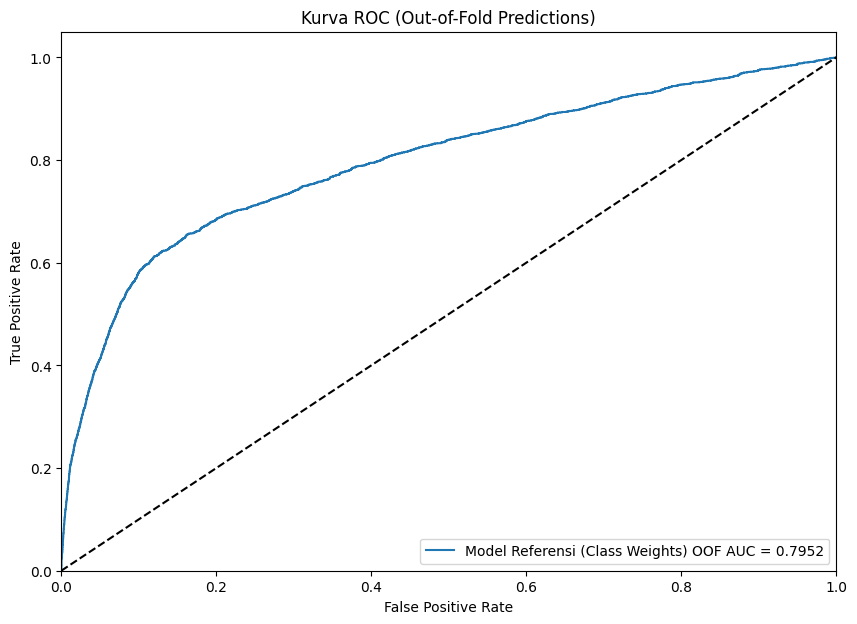

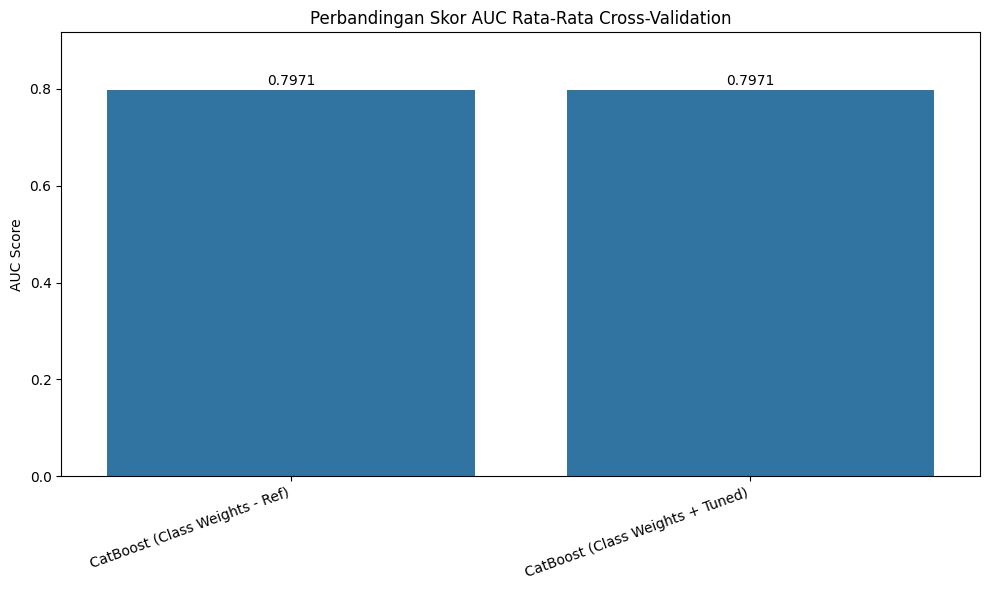

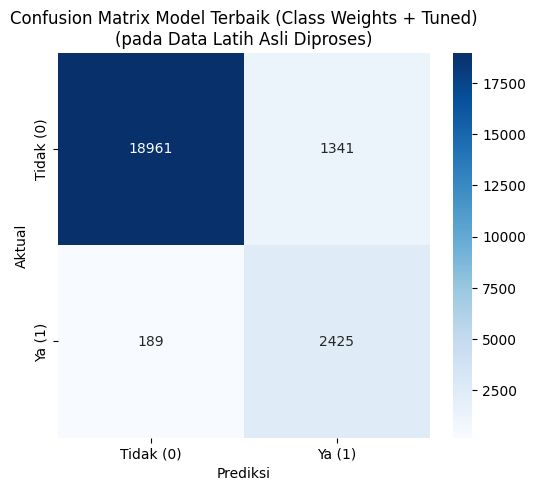


Laporan Klasifikasi Model Terbaik (Class Weights + Tuned, pada Data Latih Asli Diproses):
              precision    recall  f1-score   support

   Tidak (0)       0.99      0.93      0.96     20302
      Ya (1)       0.64      0.93      0.76      2614

    accuracy                           0.93     22916
   macro avg       0.82      0.93      0.86     22916
weighted avg       0.95      0.93      0.94     22916



In [ ]:
plt.figure(figsize=(10, 7))
if len(oof_preds_model_ref) == len(y):
    fpr_ref, tpr_ref, _ = roc_curve(y, oof_preds_model_ref); roc_auc_ref = auc(fpr_ref, tpr_ref)
    plt.plot(fpr_ref, tpr_ref, label=f'Model Referensi (Class Weights) OOF AUC = {roc_auc_ref:.4f}')

plt.plot([0, 1], [0, 1], 'k--'); plt.xlim([0.0, 1.0]); plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
plt.title('Kurva ROC (Out-of-Fold Predictions)'); plt.legend(loc="lower right"); plt.show()

auc_scores_summary = {
    'CatBoost (Class Weights - Ref)': mean_auc_model_ref,
    'CatBoost (Class Weights + Tuned)': best_auc_tuned_cw if best_auc_tuned_cw is not None else 0.0
}
plt.figure(figsize=(10, 6))
bars = sns.barplot(x=list(auc_scores_summary.keys()), y=list(auc_scores_summary.values()))
plt.title('Perbandingan Skor AUC Rata-Rata Cross-Validation'); plt.ylabel('AUC Score')
plt.xticks(rotation=20, ha="right")
for bar_idx, bar in enumerate(bars.patches):
    height = bar.get_height()
    value = list(auc_scores_summary.values())[bar_idx]
    plt.text(bar.get_x() + bar.get_width() / 2, height + 0.005, f"{value:.4f}", ha='center', va='bottom')
plt.ylim(top=max(auc_scores_summary.values()) * 1.15 if auc_scores_summary and max(auc_scores_summary.values()) > 0 else 0.1)
plt.tight_layout(); plt.show()

# Prediksi pada data latih yang diproses (X_processed) menggunakan model final_model_cw
y_pred_final_on_train_proba_cw = final_model_cw.predict_proba(X_processed)[:, 1]
threshold = 0.5
y_pred_final_on_train_binary_cw = (y_pred_final_on_train_proba_cw >= threshold).astype(int)

cm_cw = confusion_matrix(y, y_pred_final_on_train_binary_cw)
plt.figure(figsize=(6,5))
sns.heatmap(cm_cw, annot=True, fmt='d', cmap='Blues', xticklabels=['Tidak (0)', 'Ya (1)'], yticklabels=['Tidak (0)', 'Ya (1)'])
plt.title('Confusion Matrix Model Terbaik (Class Weights + Tuned)\n(pada Data Latih Asli Diproses)'); plt.xlabel('Prediksi'); plt.ylabel('Aktual'); plt.show()
print("\nLaporan Klasifikasi Model Terbaik (Class Weights + Tuned, pada Data Latih Asli Diproses):")
print(classification_report(y, y_pred_final_on_train_binary_cw, target_names=['Tidak (0)', 'Ya (1)']))

## Prediksi pada Data Test & Pembuatan Submission

In [ ]:
print("\n--- Memprediksi Data Test dengan Model Class Weights + Tuned ---")
X_test_processed = X_test_final.copy()

for col, encoder in final_ordinal_encoders.items():
    if col in X_test_processed.columns:
        X_test_processed[col] = encoder.transform(X_test_processed[[col]]).astype(int)
    else:
        X_test_processed[col] = -1
        X_test_processed[col] = X_test_processed[col].astype(int)

if nominal_cols and 'final_target_encoder' in locals():
    for nc in nominal_cols: X_test_processed[nc].fillna('unknown_TE_placeholder', inplace=True)
    X_test_processed[nominal_cols] = final_target_encoder.transform(X_test_processed[nominal_cols])
elif nominal_cols:
    print("Peringatan: TargetEncoder untuk data test tidak ditemukan.")

for col in numerical_cols:
    if col in X_processed.columns and col in X_test_processed.columns:
         median_val_train_full = X_processed[col].median()
         X_test_processed[col].fillna(median_val_train_full, inplace=True)
    elif col in X_test_processed.columns:
        X_test_processed[col].fillna(0, inplace=True)

for col_name_iter in X_test_processed.columns:
    if X_test_processed[col_name_iter].dtype == 'object':
        X_test_processed[col_name_iter] = X_test_processed[col_name_iter].apply(lambda x: 0 if isinstance(x, str) else x).astype(float)

missing_cols_test = set(X_processed.columns) - set(X_test_processed.columns)
for c_miss in missing_cols_test:
    if c_miss in ordinal_cols: X_test_processed[c_miss] = -1; X_test_processed[c_miss] = X_test_processed[c_miss].astype(int)
    elif c_miss in nominal_cols: X_test_processed[c_miss] = 0.0
    elif c_miss in numerical_cols:
         median_val_train_full = X_processed[c_miss].median() if c_miss in X_processed.columns else 0
         X_test_processed[c_miss] = median_val_train_full
    else: X_test_processed[c_miss] = 0

extra_cols_test = set(X_test_processed.columns) - set(X_processed.columns)
X_test_processed = X_test_processed.drop(columns=list(extra_cols_test), errors='ignore')
X_test_processed = X_test_processed[X_processed.columns]

if X_test_processed.isnull().any().any():
    print("NaN masih ada di X_test_processed sebelum prediksi. Mengisi dengan strategi default per tipe.")
    for col in X_test_processed.columns[X_test_processed.isnull().any()]:
        if col in ordinal_cols: X_test_processed[col].fillna(-1, inplace=True); X_test_processed[col] = X_test_processed[col].astype(int)
        elif col in numerical_cols or col in nominal_cols:
            median_fill = X_processed[col].median() if col in X_processed.columns else 0
            X_test_processed[col].fillna(median_fill, inplace=True)
        else: X_test_processed[col].fillna(0, inplace=True)

# Gunakan model final_model_cw untuk prediksi
test_pred_proba_cw = final_model_cw.predict_proba(X_test_processed)[:, 1]
test_pred_binary_cw = (test_pred_proba_cw >= threshold).astype(int)

submission_cw = pd.DataFrame({ ID_COL: customer_numbers_test, TARGET_COL: test_pred_binary_cw })
submission_cw.to_csv(OUTPUT_FILE, index=False)
print(f"\nPrediksi disimpan ke: {OUTPUT_FILE}"); print(submission_cw.head())
print(f"\nDistribusi prediksi pada data test:\n{submission_cw[TARGET_COL].value_counts(normalize=True)}")
print("\n--- Selesai ---")


--- Memprediksi Data Test dengan Model Class Weights + Tuned ---

Prediksi disimpan ke: data/DCM_DMU_2025_Model_TheOne.csv
   customer_number  berlangganan_deposito
0           445420                      0
1           585604                      0
2           888824                      0
3           816820                      0
4           542716                      0

Distribusi prediksi pada data test:
berlangganan_deposito
0    0.849537
1    0.150463
Name: proportion, dtype: float64

--- Selesai ---
